# Persistence
Here we are attempting to include temporary persistence in our workflow

## 1. Import dependencies

In [14]:
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.sqlite import SqliteSaver                           # This is the tool that we will use to save the state permanently in the sqlite database as checkpoints
from langchain_ollama.chat_models import ChatOllama
from typing import TypedDict
import sqlite3

This is for graphing purpose

In [15]:
import nest_asyncio
nest_asyncio.apply()
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import Image

## 2. Linking the model

In [16]:
llm = ChatOllama(model="llama3.1:8b")

## 3. Create a state

In [17]:
class JokeState(TypedDict):                      # The JokeState inherits a TypedDict
    topic: str
    joke: str
    explanation: str

## 5. Define the function for the graph node

In [18]:
def generate_joke(state: JokeState):

    prompt = f'generate a joke on the topic {state["topic"]}'
    response = llm.invoke(prompt).content

    return {'joke': response}

In [19]:
def generate_explanation(state: JokeState):

    prompt = f'write an explanation for the joke - {state["joke"]}'
    response = llm.invoke(prompt).content

    return {'explanation': response}

## 6. Create the graph

In [20]:
# Declare the graph:
graph = StateGraph(JokeState)                    # The StateGraph takes the state as a parameter, signifying that the "state" will be exchanged between the nodes through the edges.

# Add a nodes/states to the graph:
graph.add_node('generate_joke', generate_joke)
graph.add_node('generate_explanation', generate_explanation)

# Add the sequential edges:
graph.add_edge(START, 'generate_joke')
graph.add_edge('generate_joke', 'generate_explanation')
graph.add_edge('generate_explanation', END)

### Initialise and incorporate the checkpointer

In [21]:
conn = sqlite3.connect(database="persistence_1.db", check_same_thread=False)           # This will create the DB in case it didnot exist earlier. the check_same_thread is set to false as sqlite is designed to work on the thread it was created in and will cause issues when implementing multiple threads
checkpointer = SqliteSaver(conn)

## 7. Compile the graph while incorporating the checkpointer

In [22]:
workflow = graph.compile(checkpointer=checkpointer)

## 8. The Graph

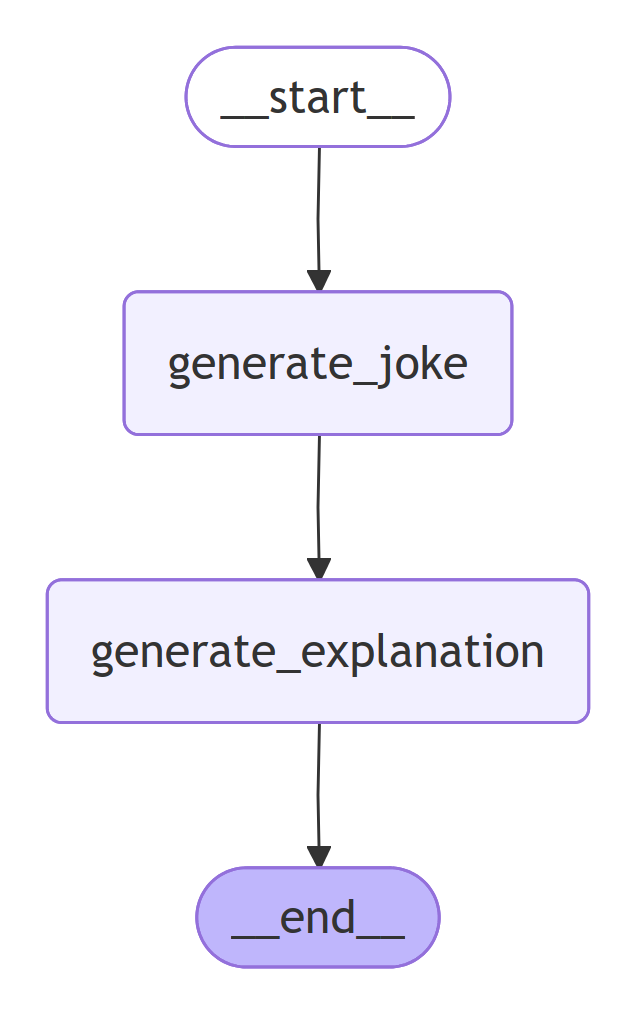

In [23]:
from IPython.display import Image
Image(workflow.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.PYPPETEER))

# 9. Incorporate the thread in config
To incorporate persistence, we are required to mention threads for each conversation, so that two different conversations do not pollute each other.

In [24]:
config1 = {"configurable": {"thread_id": "1"}}

In [25]:
config2 = {"configurable": {"thread_id": "2"}}

## 10. Run the code

In [26]:
# First Thread
final_state1 = workflow.invoke({'topic':'pizza'}, config=config1)
print(final_state1)

{'topic': 'pizza', 'joke': "Here's one:\n\nWhy was the pizza in a bad mood?\n\nBecause it was feeling crusty! (get it?)", 'explanation': 'Here\'s an explanation of the joke:\n\nThe joke is a play on words. When we say someone or something is "feeling crusty", we typically mean that they\'re irritable, annoyed, or in a bad mood. But in this case, the joke takes advantage of the fact that a pizza has a crust (a layer of dough) as one of its main components.\n\nThe humor comes from the unexpected twist on the usual meaning of "crusty". The punchline is funny because it\'s a clever wordplay on the literal definition of a pizza\'s crust, rather than using it to describe an emotional state. It\'s a lighthearted and silly joke that uses a common phrase in an unconventional way to create a comedic effect!'}


In [27]:
# Second Thread
final_state2 = workflow.invoke({'topic':'pasta'}, config=config2)
print(final_state2)

{'topic': 'pasta', 'joke': 'Why did the spaghetti go to therapy?\n\nBecause it was feeling a little "twisted"! (get it?)', 'explanation': 'A playful pun!\n\nThe joke is a play on words, using the multiple meanings of "twisted".\n\nIn this case, the speaker says the spaghetti went to therapy because it was feeling "a little twisted". On one hand, being "twisted" can imply that something or someone has a warped or abnormal personality.\n\nBut on the other hand, when we think of spaghetti, we often imagine long, curly strands. So, the phrase "feeling a little twisted" is also a clever pun, referencing the physical shape of the pasta itself – it\'s literally twisted into long, curved shapes!\n\nThe humor comes from the unexpected twist (pun intended) on the double meaning of the word "twisted", creating a lighthearted and silly connection between the pasta and its emotional state.'}


In [28]:
workflow.get_state(config1)

StateSnapshot(values={'topic': 'pizza', 'joke': "Here's one:\n\nWhy was the pizza in a bad mood?\n\nBecause it was feeling crusty! (get it?)", 'explanation': 'Here\'s an explanation of the joke:\n\nThe joke is a play on words. When we say someone or something is "feeling crusty", we typically mean that they\'re irritable, annoyed, or in a bad mood. But in this case, the joke takes advantage of the fact that a pizza has a crust (a layer of dough) as one of its main components.\n\nThe humor comes from the unexpected twist on the usual meaning of "crusty". The punchline is funny because it\'s a clever wordplay on the literal definition of a pizza\'s crust, rather than using it to describe an emotional state. It\'s a lighthearted and silly joke that uses a common phrase in an unconventional way to create a comedic effect!'}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0b259a-bd1e-66a7-8002-5acb04d619dc'}}, metadata={'source': 'loop', 'step':

In [29]:
workflow.get_state(config2)

StateSnapshot(values={'topic': 'pasta', 'joke': 'Why did the spaghetti go to therapy?\n\nBecause it was feeling a little "twisted"! (get it?)', 'explanation': 'A playful pun!\n\nThe joke is a play on words, using the multiple meanings of "twisted".\n\nIn this case, the speaker says the spaghetti went to therapy because it was feeling "a little twisted". On one hand, being "twisted" can imply that something or someone has a warped or abnormal personality.\n\nBut on the other hand, when we think of spaghetti, we often imagine long, curly strands. So, the phrase "feeling a little twisted" is also a clever pun, referencing the physical shape of the pasta itself – it\'s literally twisted into long, curved shapes!\n\nThe humor comes from the unexpected twist (pun intended) on the double meaning of the word "twisted", creating a lighthearted and silly connection between the pasta and its emotional state.'}, next=(), config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_i

In [30]:
list(workflow.get_state_history(config1))

[StateSnapshot(values={'topic': 'pizza', 'joke': "Here's one:\n\nWhy was the pizza in a bad mood?\n\nBecause it was feeling crusty! (get it?)", 'explanation': 'Here\'s an explanation of the joke:\n\nThe joke is a play on words. When we say someone or something is "feeling crusty", we typically mean that they\'re irritable, annoyed, or in a bad mood. But in this case, the joke takes advantage of the fact that a pizza has a crust (a layer of dough) as one of its main components.\n\nThe humor comes from the unexpected twist on the usual meaning of "crusty". The punchline is funny because it\'s a clever wordplay on the literal definition of a pizza\'s crust, rather than using it to describe an emotional state. It\'s a lighthearted and silly joke that uses a common phrase in an unconventional way to create a comedic effect!'}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0b259a-bd1e-66a7-8002-5acb04d619dc'}}, metadata={'source': 'loop', 'step'

In [31]:
list(workflow.get_state_history(config2))

[StateSnapshot(values={'topic': 'pasta', 'joke': 'Why did the spaghetti go to therapy?\n\nBecause it was feeling a little "twisted"! (get it?)', 'explanation': 'A playful pun!\n\nThe joke is a play on words, using the multiple meanings of "twisted".\n\nIn this case, the speaker says the spaghetti went to therapy because it was feeling "a little twisted". On one hand, being "twisted" can imply that something or someone has a warped or abnormal personality.\n\nBut on the other hand, when we think of spaghetti, we often imagine long, curly strands. So, the phrase "feeling a little twisted" is also a clever pun, referencing the physical shape of the pasta itself – it\'s literally twisted into long, curved shapes!\n\nThe humor comes from the unexpected twist (pun intended) on the double meaning of the word "twisted", creating a lighthearted and silly connection between the pasta and its emotional state.'}, next=(), config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_